In [146]:
!curl https://raw.githubusercontent.com/APSV-UPM/BusinessIntelligence/main/data/data_clean.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1326k  100 1326k    0     0  4614k      0 --:--:-- --:--:-- --:--:-- 4623k


In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd

Let's load our well known dataset of train events:

In [148]:
df = pd.read_csv("data.csv").dropna()
df.date = pd.to_datetime(df.date)

We are going to transform this train event dataset into a table where each row contains information for a single train trip. Each row will include the number of packages transported, the train used, and the trip duration.

In [149]:
t = df.groupby("trip_id").agg({"train_name":"first", "date":{'min', 'max'}, "cargo":'max', "fuel_level":{"min", "max"}, "cargo_type":"last"})
t.columns.map("_".join)

Index(['train_name_first', 'date_min', 'date_max', 'cargo_max',
       'fuel_level_min', 'fuel_level_max', 'cargo_type_last'],
      dtype='object')

In [150]:
trip_summary = df.groupby("trip_id").agg({"train_name":"first", "date":{'min', 'max'}, "cargo":'max', "fuel_level":{"min", "max"}, "cargo_type":"last"})
trip_summary.columns = trip_summary.columns.map("_".join)
trip_summary.columns = trip_summary.rename(columns={"date_min":"start_date", "date_max":"end_date", "train_name_first":"train_name", "cargo_max":"cargo", "cargo_type_last":"cargo_type"}).columns
trip_summary.reset_index(inplace=True, drop=True)
trip_summary["trip_duration"] = (trip_summary.end_date - trip_summary.start_date).dt.total_seconds()
trip_summary["fuel_consumed"] = trip_summary.fuel_level_max - trip_summary.fuel_level_min
trip_summary

,train_name,start_date,end_date,cargo,fuel_level_min,fuel_level_max,cargo_type,trip_duration,fuel_consumed
0,VXRCS,2025-05-17 10:00:00,2025-05-17 17:57:01,9,817.632,1200.00,Electronics,28621.0,382.368
1,HHEXD,2025-01-23 10:00:00,2025-01-23 15:06:39,44,130.475,800.00,Machinery,18399.0,669.525
2,UDAXI,2024-08-13 18:00:00,2024-08-13 21:32:04,37,730.400,1000.00,Electronics,12724.0,269.600
3,HHEXD,2025-07-31 10:00:00,2025-07-31 15:05:31,46,367.000,800.00,Food,18331.0,433.000
4,HHEXD,2024-12-16 10:00:00,2024-12-16 14:58:02,48,468.800,800.00,Electronics,17882.0,331.200
...,...,...,...,...,...,...,...,...,...
727,UDAXI,2025-08-13 18:00:00,2025-08-13 21:30:44,80,776.344,1000.00,Textiles,12644.0,223.656
728,UDAXI,2025-04-10 18:00:00,2025-04-10 22:16:44,96,549.760,1000.00,Chemicals,15404.0,450.240
729,HHEXD,2025-05-12 10:00:00,2025-05-12 14:56:07,30,381.150,800.00,Food,17767.0,418.850
730,UDAXI,2025-01-10 18:00:00,2025-01-10 21:40:08,80,393.424,606.64,Textiles,13208.0,213.216


Most ML algorithms work with numerical values; therefore, we must convert columns that contain text (categorical variables) into numbers. The simplest way to do this is to use a LabelEncoder, which assigns an integer to each category it finds.

In [151]:
from sklearn import preprocessing
train_name_encoder = preprocessing.LabelEncoder().fit(trip_summary.train_name.unique())

for i in range(len(train_name_encoder.classes_)):
    print(f"""{train_name_encoder.classes_[i]} encoded as {i}""")
trip_summary["train_name_encoded"] = pd.Series(train_name_encoder.transform(trip_summary.train_name.values), index = trip_summary.index)

HHEXD encoded as 0
UDAXI encoded as 1
VXRCS encoded as 2


Now we need to do the same for the `cargo_type` column. Use the next cell to do it, and don't forget to save the encoder for later use.

In [152]:
# Encode cargo_type column
cargo_type_encoder = preprocessing.LabelEncoder().fit(trip_summary.cargo_type.unique())

# Print the encoding mapping for clarity
for i in range(len(cargo_type_encoder.classes_)):
    print(f"""{cargo_type_encoder.classes_[i]} encoded as {i}""")

# Apply the encoding and create a new column
trip_summary["cargo_type_encoded"] = pd.Series(
    cargo_type_encoder.transform(trip_summary.cargo_type.values),
    index=trip_summary.index
)


Chemicals encoded as 0
Electronics encoded as 1
Food encoded as 2
Machinery encoded as 3
Textiles encoded as 4


### Train and test
The main idea behind machine learning is that the algorithm observes a training set of samples, which should be representative of the data we're working with. From this training data, the algorithm learns patterns that describe the data and generates a model that can reproduce the observed behavior. Then, using a *different* set of samples (the test set), we evaluate how accurate the model is by measuring the difference between the model's outputs and the correct answers. It is very important not to use the same data for training and testing.

Let's see an example.
We will use a popular dataset in ML called the Iris dataset. This dataset contains measurements of flowers and the flower species (for more info, see https://archive.ics.uci.edu/ml/datasets/iris). As we will see, the task in this example is classification.
The dataset consists of observations with four numeric features and one categorical target. The model's task is to predict the target class of a sample from its numeric features.


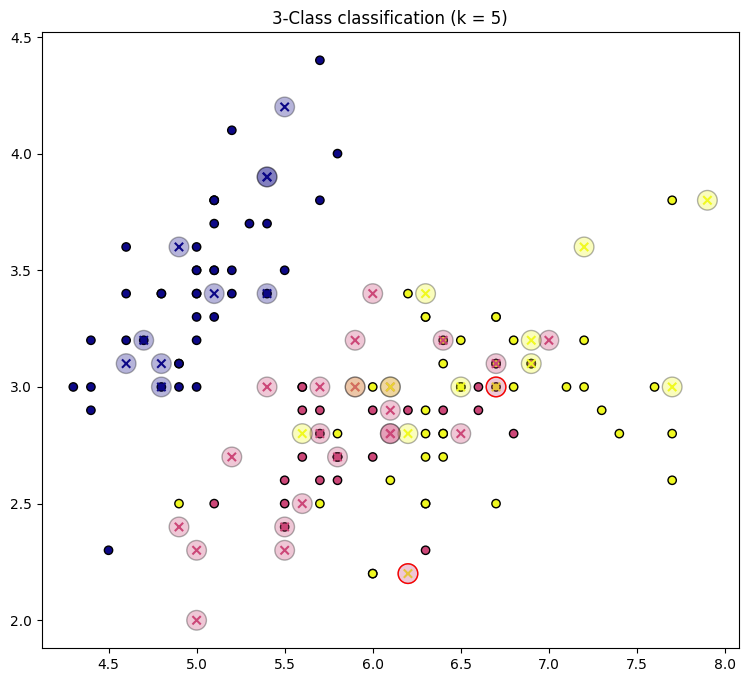

Model accuracy: 95.56%


In [153]:
# This example is based on one example from the scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn import neighbors, datasets
from sklearn import model_selection

x_feature = 0
y_feature = 1

n_neighbors = 5

iris = datasets.load_iris()

# In this notebook, we will always use x as the feature vector and y as the target
X = iris.data
y = iris.target

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.3)

clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(x_train, y_train)
y_out = clf.predict(x_test)

fig,ax = plt.subplots(figsize=(9, 8))

ax.scatter(x_train[:, x_feature], x_train[:, y_feature], c=y_train, cmap="plasma", edgecolors='k')
ax.scatter(x_test[:, x_feature], x_test[:, y_feature], c=y_out, cmap="plasma", marker = "x")
ax.scatter(x_test[:, x_feature], x_test[:, y_feature], c=y_test, cmap="plasma", alpha=0.3, marker = "o", s=200, edgecolors='k')
ax.scatter(x_test[y_out != y_test, x_feature], x_test[y_out != y_test, y_feature], facecolors='none', edgecolors='r', s=200)


ax.set_title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

print("Model accuracy: {:.2f}%".format(np.average(y_out==y_test)*100))

Although the dataset has four dimensions, the plot shows only two, which is easier to visualize. The colors represent different flower types. Dots are training data and crosses are test data. The background color of each test sample indicates the true class, and a sample is surrounded by a red circle if it was misclassified. Accuracy is the proportion of correct classifications made by the model.

### K-Fold Cross-Validation
Ensuring that the partition of the data used for training is representative can be difficult. For example, the training split might not contain samples of one class, or the test split might be particularly easy to classify.

Cross-validation is a set of techniques that addresses this problem by performing several train/test runs using different partitions each time. The most basic and widely used method is K-Fold cross-validation.
In K-Fold, we choose a number k (usually between 5 and 10) and divide the dataset into k folds. We train the model k times; in each iteration we use k-1 folds for training and the remaining fold for testing. The final evaluation is the average of the evaluations from each iteration.

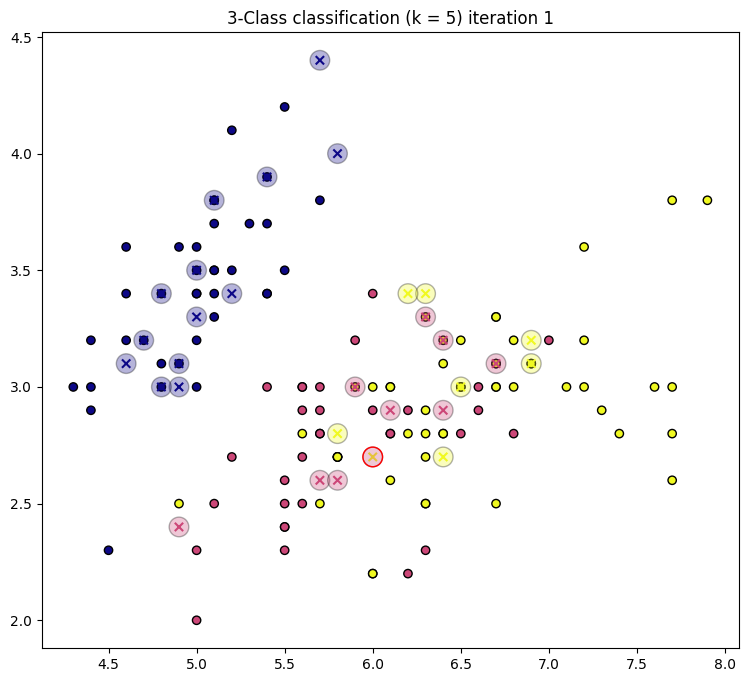

Iteration 1: Model accuracy: 96.67%
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1 1 2 2 2 2 2 2 2]


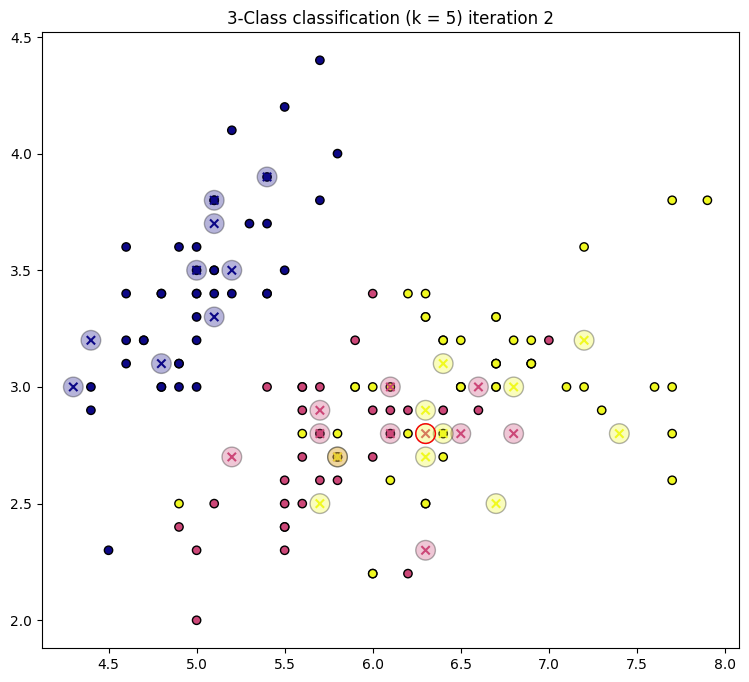

Iteration 2: Model accuracy: 96.67%
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 2 2]


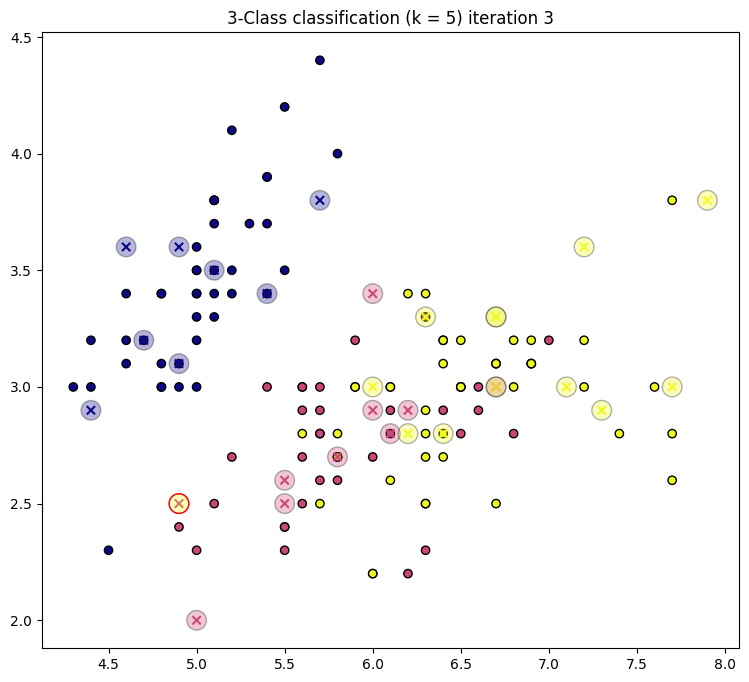

Iteration 3: Model accuracy: 96.67%
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2]


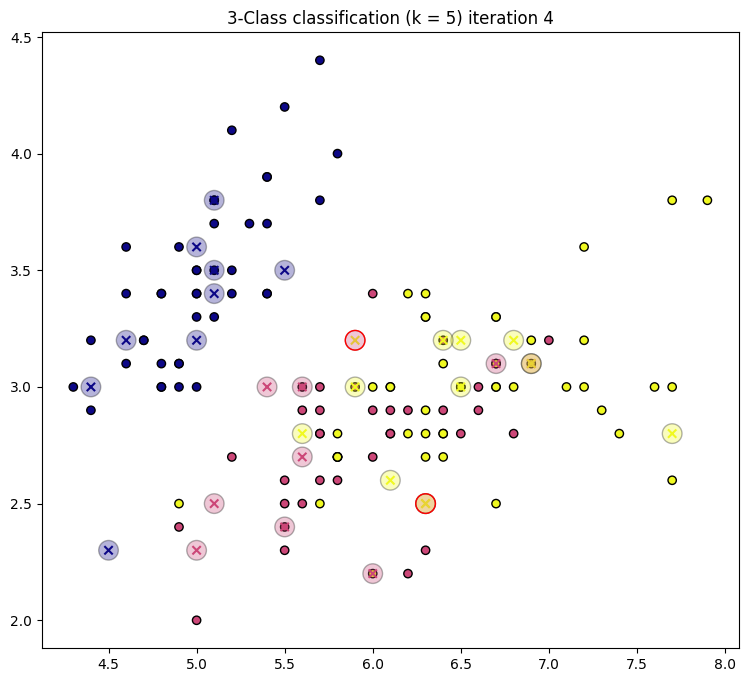

Iteration 4: Model accuracy: 93.33%
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


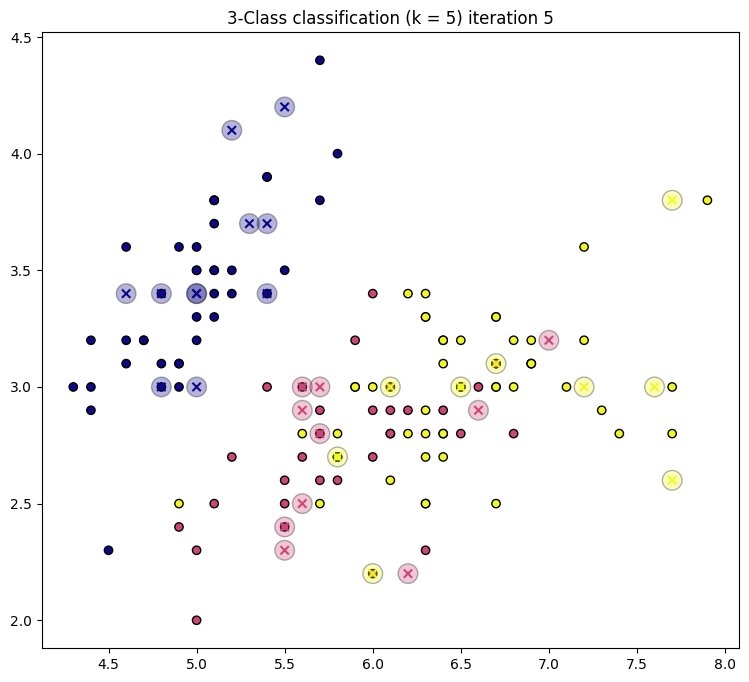

Iteration 5: Model accuracy: 100.00%
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
Global accuracy: 96.67%


In [154]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k,shuffle=True)
accuracies = []
i=0
for train, test in kf.split(X): # train and test are the indices of the samples that will be used in each set
    i+=1
    x_train, x_test, y_train, y_test = X[train], X[test], y[train], y[test]
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(x_train, y_train)
    y_out = clf.predict(x_test)


    fig,ax = plt.subplots(figsize=(9, 8))
    ax.scatter(x_train[:, x_feature], x_train[:, y_feature], c=y_train, cmap="plasma", edgecolors='k')
    ax.scatter(x_test[:, x_feature], x_test[:, y_feature], c=y_out, cmap="plasma", marker = "x")
    ax.scatter(x_test[:, x_feature], x_test[:, y_feature], c=y_test, cmap="plasma", alpha=0.3, marker = "o", s=200, edgecolors='k')
    ax.scatter(x_test[y_out != y_test, x_feature], x_test[y_out != y_test, y_feature], facecolors='none', edgecolors='r', s=200)
    ax.set_title("3-Class classification (k = %i) iteration %i" % (n_neighbors,i))
    plt.show()
    accuracy = np.average(y_out==y_test)*100
    accuracies.append(accuracy)
    print("Iteration {}: Model accuracy: {:.2f}%".format(i,accuracy))
    print(y_test)
    print(y_out)
print("Global accuracy: {:.2f}%".format(np.average(accuracies)))

## Regression
Regression is a type of ML task where the objective is to predict a numeric value from input features. For example, predicting the number of products that will be sold based on previous sales, or estimating the probability that the stock market will rise tomorrow.

The simplest example is finding the relationship between two variables.

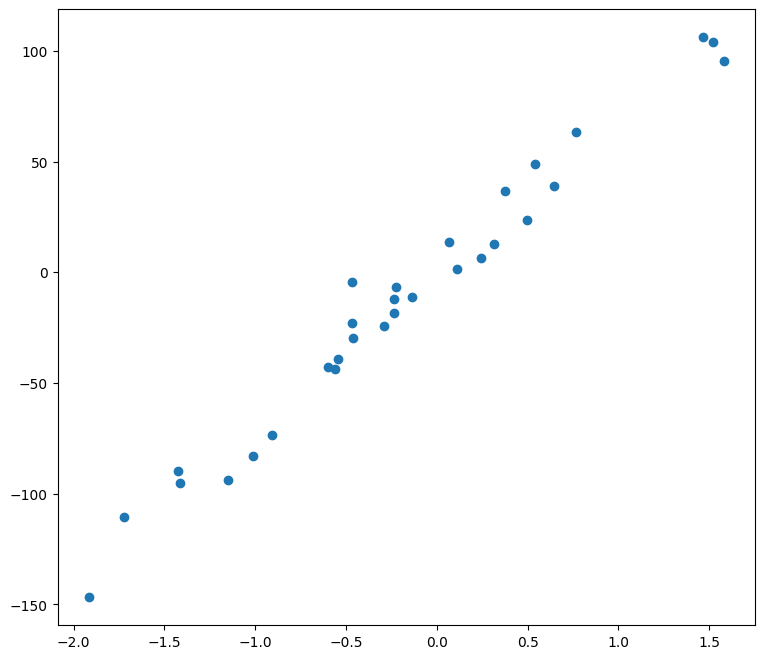

In [155]:
from sklearn import datasets
import math

x, y = datasets.make_regression(n_samples=30, n_features=1, noise=10, random_state=42)
# try to modify the relation between x and y or play with the noise value
#y = y**2
fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y)
plt.show()

Problems in the real world are more complicated, the target (variable we want to predict) usually depends on more variables (features).

### Some popular algorithms
There are many algorithms that can be used for regression. Each has advantages and disadvantages depending on the problem; discussing them in depth is beyond the scope of this course. We'll try them with basic configurations and keep the one that best fits our case.

#### Linear regression
This is the simplest regression model. The algorithm tries to minimize the error for a function like $Y = aX + b$, where $Y$ is the target and $X$ is the input/features.

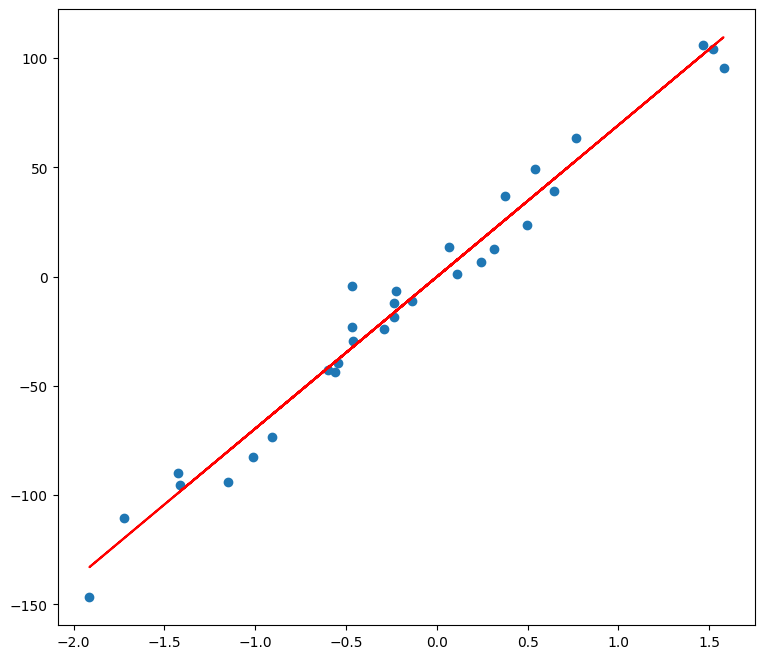

In [156]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x,y)
fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y)
ax.plot(x,model.predict(x), "r")
plt.show()

#### Decision Tree
This model is based on a tree structure in which each node represents a decision and each leaf an output. https://en.wikipedia.org/wiki/Decision_tree

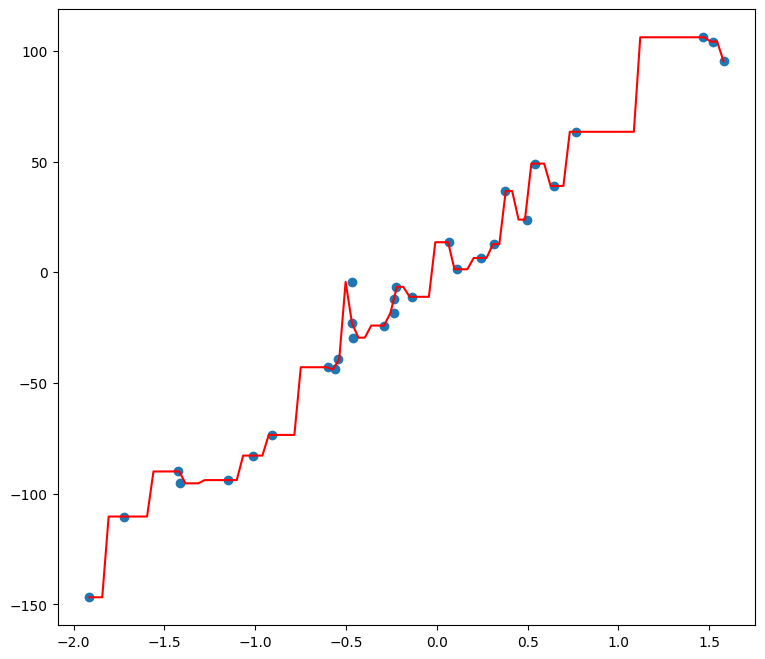

In [157]:
from sklearn.tree import DecisionTreeRegressor
x_test= np.linspace(x.min(),x.max(), 100)[:, np.newaxis]

model = DecisionTreeRegressor().fit(x,y)
fig,ax = plt.subplots(figsize=(9, 8))
ax.scatter(x, y)
ax.plot(x_test ,model.predict(x_test),"r")

plt.show()

#### Random Forest
This model is an ensemble method composed of multiple decision trees. Each tree predicts an output, and the random forest's output is the average (or majority vote for classification) of those tree outputs.

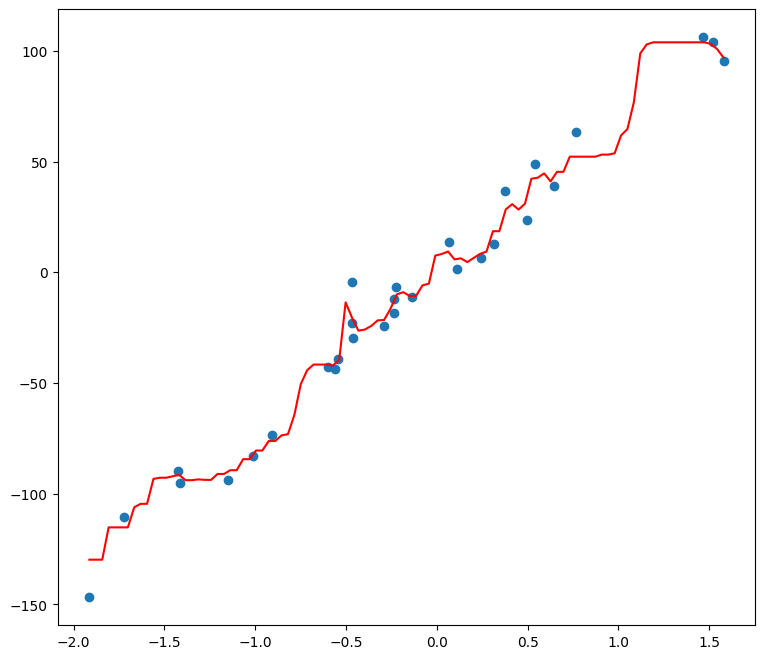

In [158]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x, y)
plt.plot(x_test ,model.predict(x_test), "r")
plt.show()

#### K Nearest Neighbors
Given an input, the output of this algorithm will be the average of the $k$ nearest points in the training set.

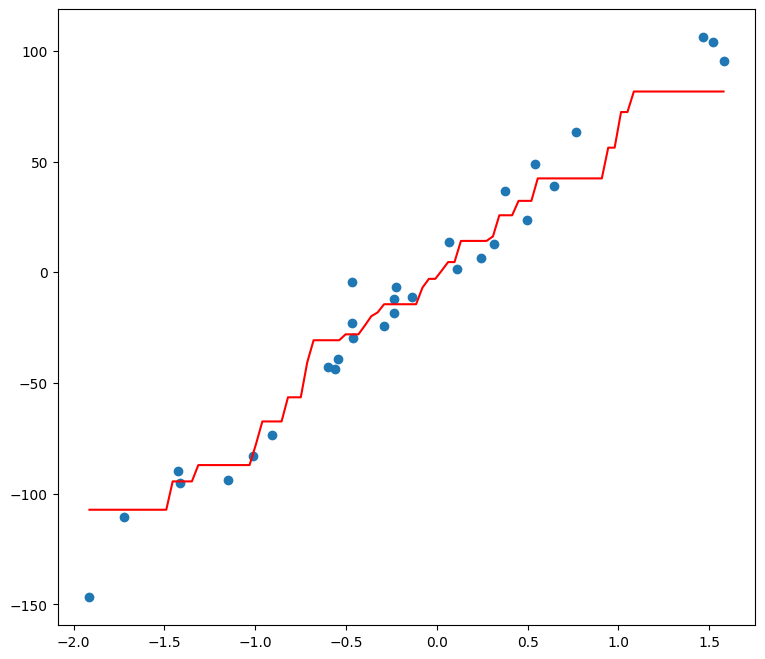

In [159]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x, y)
plt.plot(x_test ,model.predict(x_test), "r")
plt.show()

#### Perceptron
This is a simple artificial neural network (see https://en.wikipedia.org/wiki/Artificial_neural_network). Unlike some of the models above, neural networks often behave like a "black box" and it's hard to inspect exactly how they compute outputs.

Don't worry if you get a warning when running this model.

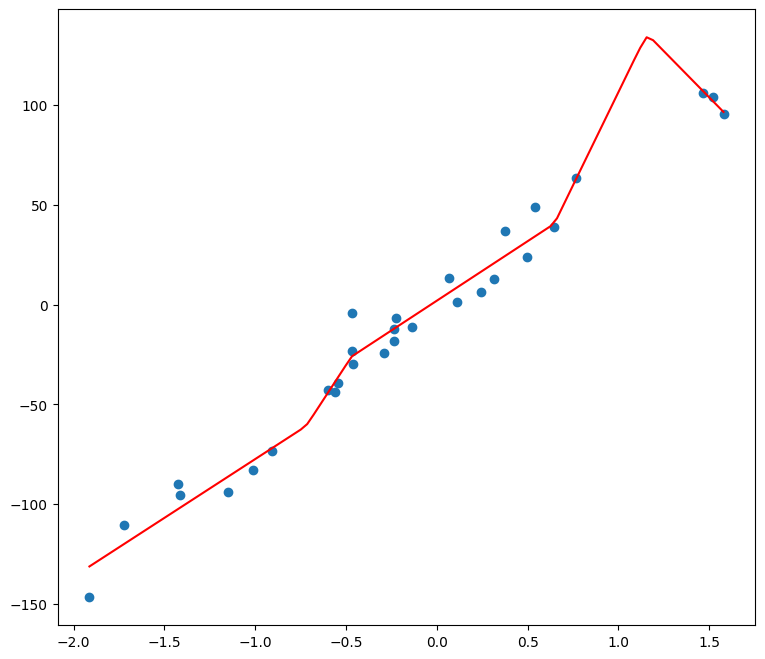

In [160]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(max_iter=50000).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x, y)
plt.plot(x_test ,model.predict(x_test), "r")
plt.show()

### How to evaluate a regression model
We have trained five models and we can expect some to perform better than others, but we need a formal way to evaluate them. Several metrics measure the error between the model's output and the true values on the test data; the lower the error, the better the model. Here are some common metrics:

1. Max error: $max(| y_i - \hat{y}_i |)$

2. Mean absolute error or MAE: $\frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$

3. Mean squared error or MSE: $\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2$

Don't worry about the math, scikit-learn will compute these metrics for us.

Remember about K-Folds Cross Validation when evaluating the models.

In [161]:
from sklearn.metrics import  mean_absolute_error, mean_squared_error, max_error
models = {"Linear Regression":LinearRegression(), \
          "Decision Tree": DecisionTreeRegressor(), \
          "Random Forest": RandomForestRegressor(n_estimators=100), \
          "Nearest Neighbors": KNeighborsRegressor(n_neighbors=5), \
          "Perceptron": MLPRegressor(max_iter=2000)}

x, y = datasets.make_regression(n_samples=30, n_features=1, noise=10)
k = 3
kf = KFold(n_splits=k,shuffle=True)
for name in models:
    print("Start training models of {}".format(name))
    i = 0
    me_global = []
    mae_global = []
    mse_global = []
    for train, test in kf.split(x):
        i+=1
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = models[name].fit(x_train,y_train)
        y_out = model.predict(x_test)
        # We have to provide the real value of the target and the model's output
        me = max_error(y_test, y_out)
        mae = mean_absolute_error(y_test, y_out)
        mse = mean_squared_error(y_test, y_out)
        me_global.append(me)
        mae_global.append(mae)
        mse_global.append(mse)
        print("Iteration {}: me={:.4f} mae={:.4f} mse={:.4f}".format(i,me, mae, mse))
    print("Global: me={:.4f} mae={:.4f} mse={:.4f}\n".format(np.average(me_global), np.average(mae_global), np.average(mse_global)))

Start training models of Linear Regression
Iteration 1: me=22.3191 mae=8.9849 mse=137.6089
Iteration 2: me=31.9462 mae=9.6758 mse=181.0374
Iteration 3: me=19.9499 mae=9.2223 mse=129.9518
Global: me=24.7384 mae=9.2943 mse=149.5327

Start training models of Decision Tree
Iteration 1: me=28.2830 mae=14.7628 mse=264.6804
Iteration 2: me=42.0642 mae=15.6437 mse=335.7955
Iteration 3: me=24.6053 mae=11.6633 mse=183.2265
Global: me=31.6508 mae=14.0233 mse=261.2341

Start training models of Random Forest
Iteration 1: me=22.9228 mae=10.3530 mse=159.6583
Iteration 2: me=23.9603 mae=11.8401 mse=199.0199
Iteration 3: me=39.3095 mae=13.4460 mse=299.6152
Global: me=28.7309 mae=11.8797 mse=219.4311

Start training models of Nearest Neighbors
Iteration 1: me=38.0416 mae=13.6784 mse=284.9038
Iteration 2: me=24.0943 mae=9.8432 mse=150.1486
Iteration 3: me=23.9700 mae=9.4483 mse=133.6494
Global: me=28.7019 mae=10.9900 mse=189.5673

Start training models of Perceptron


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1: me=20.3453 mae=6.0873 mse=74.5626


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2: me=24.7195 mae=10.5306 mse=164.9885
Iteration 3: me=30.1137 mae=11.5996 mse=195.6321
Global: me=25.0595 mae=9.4058 mse=145.0611



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Try it
Now it's your turn to create a prediction model. After reading the datasets, we have transformed and prepared them in a format suitable for the algorithms shown above.

Let's try to build a regression model to predict the fuel consumed during a trip. If we want to use this model as a practical prediction tool, the features we use must be available before the trip starts. That means we cannot use final fuel level or trip duration as features, since we want to predict the target before the trip begins.
Train several regression models using different algorithms and keep the best one. Then answer the following questions:

- What features did you use to train the model?
- Which algorithm performed best?
- What metric did you use to select the best model?

In [162]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# To extract the features and target from the trip_summary dataframe, follow the example below:

X = trip_summary[["train_name_encoded", "cargo_type_encoded", "cargo","fuel_level_max"]].values
y = trip_summary["fuel_consumed"].values

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define several regression models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Train and evaluate all models
results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}")

# Show results in a DataFrame for easy comparison
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\nModel comparison:")
display(results_df)

# Select the best model (highest R²)
best_model_name = results_df.iloc[0]["Model"]
model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Example prediction (as requested in the notebook)
# Train UDAXI - 50 packages of Electronics
encoded_name = train_name_encoder.transform(["UDAXI"])[0]
encoded_cargo_type = cargo_type_encoder.transform(["Electronics"])[0]

predicted_fuel = model.predict([[encoded_name, encoded_cargo_type, 50,1000]])[0]
print(f"\nPredicted fuel consumption for UDAXI (50 Electronics): {predicted_fuel:.2f} units")


Linear Regression: MAE=101.10, RMSE=127.19, R2=0.128
Decision Tree: MAE=19.53, RMSE=28.68, R2=0.956
Random Forest: MAE=17.27, RMSE=24.79, R2=0.967

Model comparison:


,Model,MAE,RMSE,R2
2,Random Forest,17.267307,24.785937,0.966877
1,Decision Tree,19.526081,28.679184,0.955654
0,Linear Regression,101.096395,127.192688,0.127745


Best model: Random Forest

Predicted fuel consumption for UDAXI (50 Electronics): 297.55 units


In [163]:
# To evaluate this task, you will be asked to run your model in a given situation.
# For example, the train UDAXI has a scheduled trip on 2025-01-23 at 10:00:00, its cargo will be 50 packages of electronics and it will be loaded with 800 units of fuel.
# How much fuel will it consume during the trip?

# Suppose that your model is called "model" and your input is a vector of [train_name, cargo]. Then, you will have to run the following code:
# transform the name of the train to the encoded value: encoded_name = train_name_encoder.transform(["UDAXI"])[0]
# make the prediction: model.predict([[encoded_name,50]])
# the last line will return the fuel consumption
# Case 1
encoded_name_1 = train_name_encoder.transform(["VXRCS"])[0]
encoded_cargo_type_1 = cargo_type_encoder.transform(["Chemicals"])[0]
pred_1 = model.predict([[encoded_name_1, encoded_cargo_type_1, 34,1200]])[0]
print(f"VXRCS - 34 packages of Chemicals -> Predicted fuel consumed: {pred_1:.2f} units")

# Case 2
encoded_name_2 = train_name_encoder.transform(["HHExd".upper()])[0]  # normalize to match
encoded_cargo_type_2 = cargo_type_encoder.transform(["Chemicals"])[0]
pred_2 = model.predict([[encoded_name_2, encoded_cargo_type_2, 46,800]])[0]
print(f"HHExd - 46 packages of Chemicals -> Predicted fuel consumed: {pred_2:.2f} units")

# Case 3
encoded_name_3 = train_name_encoder.transform(["UDAXI"])[0]
encoded_cargo_type_3 = cargo_type_encoder.transform(["Chemicals"])[0]
pred_3 = model.predict([[encoded_name_3, encoded_cargo_type_3, 95,1000]])[0]
print(f"UDAXI - 95 packages of Chemicals -> Predicted fuel consumed: {pred_3:.2f} units")

# Case 4
encoded_name_4 = train_name_encoder.transform(["HHExd".upper()])[0]
encoded_cargo_type_4 = cargo_type_encoder.transform(["Electronics"])[0]
pred_4 = model.predict([[encoded_name_4, encoded_cargo_type_4, 39,800]])[0]
print(f"HHExd - 39 packages of Electronics -> Predicted fuel consumed: {pred_4:.2f} units")

VXRCS - 34 packages of Chemicals -> Predicted fuel consumed: 604.01 units
HHExd - 46 packages of Chemicals -> Predicted fuel consumed: 509.55 units
UDAXI - 95 packages of Chemicals -> Predicted fuel consumed: 522.78 units
HHExd - 39 packages of Electronics -> Predicted fuel consumed: 349.18 units


## Classification
Another common ML task is classification; in this case the target is a class label or categorical variable, as with the Iris dataset.

When discussing classification tasks there are two main cases: binary classification (target is positive or negative) and multiclass classification (target is one of several categories).

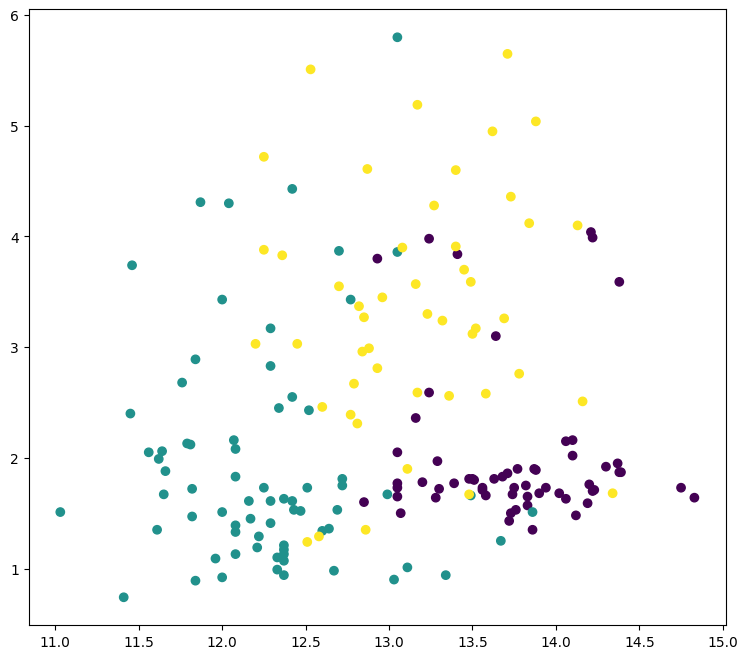

In [164]:
wine = datasets.load_wine()
x = wine.data[:, 0:2]  # we only take the first two features for easy
y = wine.target
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)
plt.show()

To better understanding of the models output, we can visualize the decision boundaries. A decision boundary is a region in the feature space where the model changes its predicted class. To represent this, we can create a grid of points that cover the feature space and use the model to predict the class for each point. Then we can color each point according to its predicted class, which will show us how the model divides the feature space.

In [165]:
# For decision regions
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


### Some popular models
As with regression, there are many algorithms for classification. Many algorithms have both regression and classification variants.

The following plots show decision regions — the areas in feature space where the model assigns a given class.

#### Logistic regression
Don't be misled by the name: Logistic Regression is used for classification. The model estimates the probability that a sample belongs to a given class using the logistic function.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


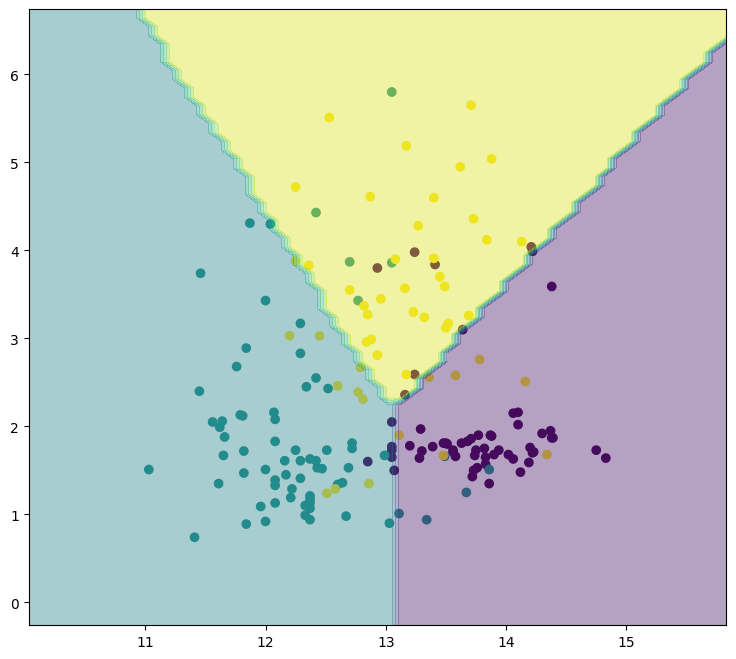

In [166]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class="auto", solver="lbfgs").fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### Decision Tree

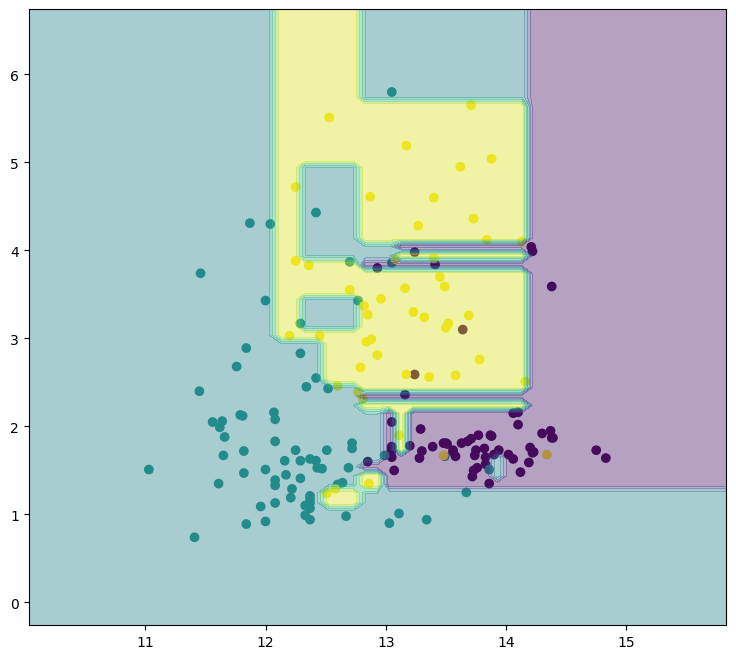

In [167]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### Random Forest

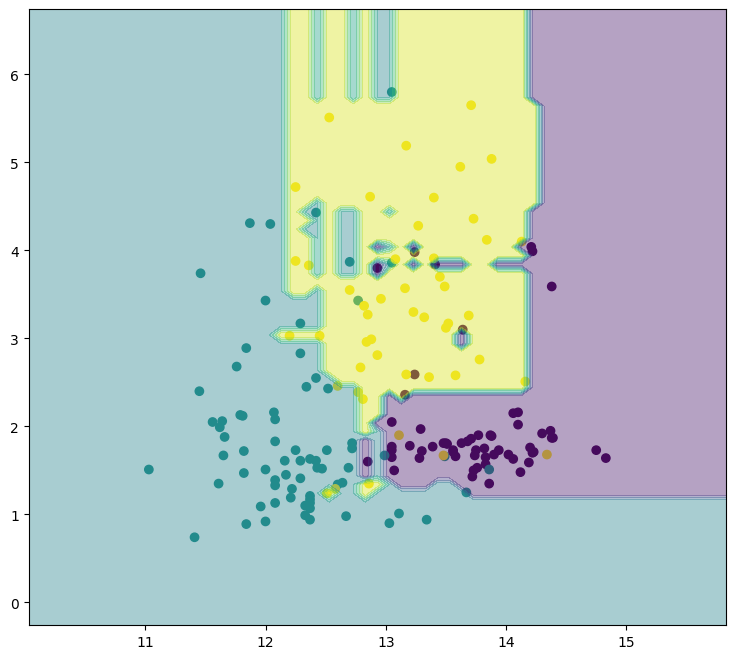

In [168]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### K Nearest Neighbors

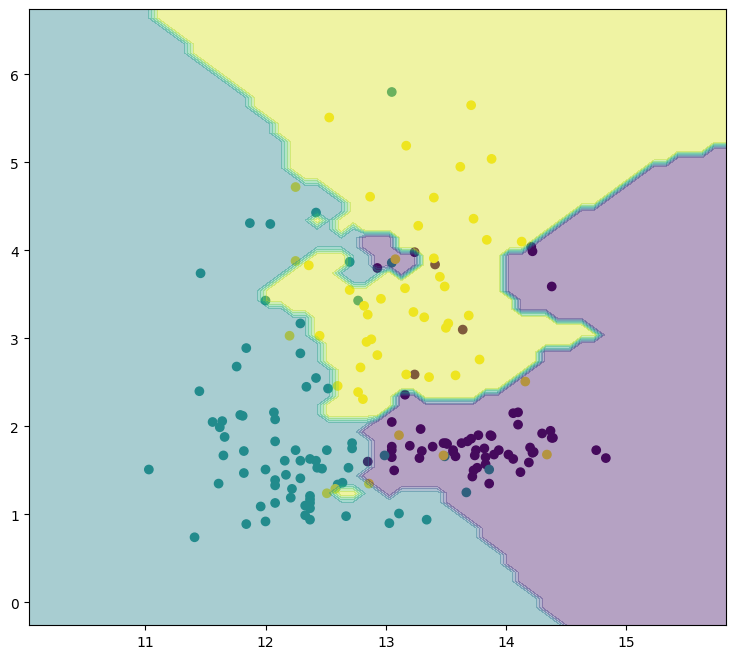

In [169]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

#### Perceptron

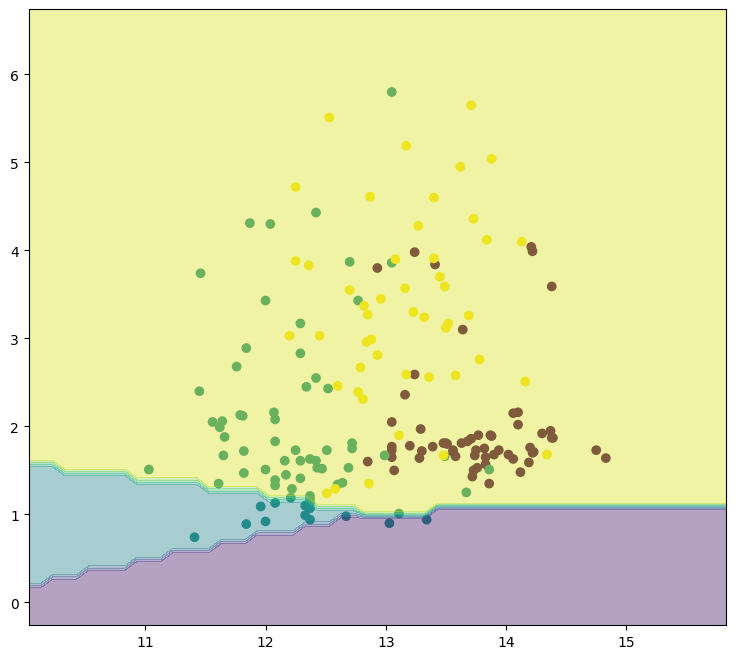

In [170]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=2000).fit(x,y)
plt.figure(figsize=(9, 8))
plt.scatter(x[:,0], x[:,1],c=y)

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.show()

### How to evaluate a classification model
For classification, the output is a class label, so we do not measure error the same way as in regression. Instead, we compute ratios such as accuracy, precision, and recall. The most intuitive measure is accuracy — the fraction of correct predictions out of all predictions. However, accuracy can be misleading in many practical situations.

### Confusion matrix
The confusion matrix is a primary tool for evaluating classification models (https://en.wikipedia.org/wiki/Confusion_matrix). It is defined as:

"By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$."

In other words, rows represent the true classes and columns represent the predicted classes. The confusion matrix shows how many samples were correctly classified and which classes are commonly confused.

In the binary classification case, the matrix has 2 rows and 2 columns, and each cell has a conventional name.

Some metrics derived from the confusion matrix include:
1. Precision: the ratio of true positives over predicted positives $\frac{TP}{TP+FP}$
2. Accuracy: the ratio of correctly predicted samples over the total $\frac{TP+TN}{TP+FP+TN+FN}$
3. Recall (Sensitivity): the ratio of true positives over actual positives $\frac{TP}{TP+FN}$
4. F1 score: the harmonic mean of precision and recall $\frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2TP}{2TP + FP + FN}$

More complex metrics exist, but for this course the F1 score is sufficient. Again, scikit-learn provides functions to compute these metrics.

In [171]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# x = wine.data # uncomment this line to use all features

models = {"Logistic Regression":LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=2000), \
          "Decision Tree": DecisionTreeClassifier(), \
          "Random Forest": RandomForestClassifier(n_estimators=100), \
          "Nearest Neighbors": KNeighborsClassifier(n_neighbors=5), \
          "Perceptron": MLPClassifier(max_iter=2000)}

for name in models:
    print("Start training models of {}".format(name))
    i = 0
    f1_global = []
    for train, test in kf.split(x):
        i+=1
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        model = models[name].fit(x_train,y_train)
        y_out = model.predict(x_test)
        # We have to provide the real value of the target and the model's output
        f1_global.append(f1_score(y_test, y_out, average="weighted", zero_division=0))
        print(confusion_matrix(y_test, y_out))
        print(classification_report(y_test, y_out))
    print("Global: f1={:.4f}\n".format(np.average(f1_global)))

Start training models of Logistic Regression
[[16  3  1]
 [ 3 21  1]
 [ 2  2 11]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.81      0.84      0.82        25
           2       0.85      0.73      0.79        15

    accuracy                           0.80        60
   macro avg       0.81      0.79      0.80        60
weighted avg       0.80      0.80      0.80        60



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[[16  0  2]
 [ 1 21  1]
 [ 2  4 12]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.84      0.91      0.88        23
           2       0.80      0.67      0.73        18

    accuracy                           0.83        59
   macro avg       0.83      0.82      0.82        59
weighted avg       0.83      0.83      0.83        59

[[16  2  3]
 [ 2 17  4]
 [ 3  5  7]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.71      0.74      0.72        23
           2       0.50      0.47      0.48        15

    accuracy                           0.68        59
   macro avg       0.66      0.66      0.66        59
weighted avg       0.67      0.68      0.68        59

Global: f1=0.7675

Start training models of Decision Tree
[[18  0  1]
 [ 1 19  3]
 [ 2  4 12]]
              precision    recall  f1-score   support

           0  

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[[21  0  3]
 [ 0 19  3]
 [ 4  2  8]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       0.90      0.86      0.88        22
           2       0.57      0.57      0.57        14

    accuracy                           0.80        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.80      0.80      0.80        60

[[15  0  3]
 [ 4 19  2]
 [ 1  5 10]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.79      0.76      0.78        25
           2       0.67      0.62      0.65        16

    accuracy                           0.75        59
   macro avg       0.74      0.74      0.74        59
weighted avg       0.75      0.75      0.74        59

[[15  2  0]
 [ 0 23  1]
 [ 3  4 11]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

[[14  0  3]
 [ 1 19  3]
 [ 3  2 14]]
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.90      0.83      0.86        23
           2       0.70      0.74      0.72        19

    accuracy                           0.80        59
   macro avg       0.79      0.80      0.79        59
weighted avg       0.80      0.80      0.80        59

Global: f1=0.3995



### Try it

Imagine that the packages that arrive to the last station are not labeled and we cannot identify what type of cargo they contain. Let's build a classification model to help us to guess the correct cargo type. In this case, we will use the model at the end of the trip, so we can use all available features except the cargo type, which is the target. As before, train several classification models using different algorithms and keep the best one. Then answer the following questions:

- Which algorithm performs best?
- What is the average F1 score for that algorithm?

Some algorithms provide estimates of feature importance. This is useful to understand which features matter most. Tree-based models (Decision Tree and Random Forest) expose this via the attribute `feature_importances_`. The higher the value, the more important the feature. In this case, which feature is most important?

In [172]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define features (everything EXCEPT cargo_type)
X = trip_summary[[
    "train_name_encoded",
    "cargo",
    "fuel_level_min",
    "fuel_level_max",
    "trip_duration",
    "fuel_consumed"
]].values

# Target variable (the cargo type we want to predict)
y = trip_summary["cargo_type_encoded"].values

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and train several classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred, average="weighted")  # weighted average for multiclass
    results.append({"Model": name, "F1 Score": f1})
    print(f"{name}: F1 Score = {f1:.3f}")

# Compare results
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\nModel comparison:")
display(results_df)

# Select the best model
best_model_name = results_df.iloc[0]["Model"]
model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Feature importance (for tree-based models)
if hasattr(model, "feature_importances_"):
    importances = pd.DataFrame({
        "Feature": ["train_name_encoded", "cargo", "fuel_level_min", "fuel_level_max", "trip_duration", "fuel_consumed"],
        "Importance": model.feature_importances_
    }).sort_values(by="Importance", ascending=False)
    print("\nFeature importance:")
    display(importances)

# Example prediction
# The train HHEXD arrives with 40 packages.
# Started at 2025-01-15 08:00:00 with 800 units of fuel, ended at 12:00:00 with 350 units.
encoded_name = train_name_encoder.transform(["HHEXD"])[0]
cargo = 40
fuel_level_min = 350
fuel_level_max = 800
trip_duration = (12 - 8) * 3600  # 4 hours = 14400 seconds
fuel_consumed = fuel_level_max - fuel_level_min

pred = model.predict([[encoded_name, cargo, fuel_level_min, fuel_level_max, trip_duration, fuel_consumed]])[0]
predicted_type = cargo_type_encoder.inverse_transform([pred])[0]

print(f"\nPredicted cargo type for HHEXD with 40 packages: {predicted_type}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: F1 Score = 0.587
Decision Tree: F1 Score = 0.838
Random Forest: F1 Score = 0.875

Model comparison:


,Model,F1 Score
2,Random Forest,0.874718
1,Decision Tree,0.838476
0,Logistic Regression,0.587304


Best model: Random Forest

Feature importance:


,Feature,Importance
5,fuel_consumed,0.388481
2,fuel_level_min,0.257515
4,trip_duration,0.131786
3,fuel_level_max,0.098082
1,cargo,0.083761
0,train_name_encoded,0.040376



Predicted cargo type for HHEXD with 40 packages: Food


In [173]:
# To evaluate this task, you will be asked to run your model in a given situation.
# For example, the train HHEXD arrives to the last station. It has transported 40 packages.
# The trip started at 2025-01-15 08:00:00 with 800 units of fuel and ended at 2025-01-15 12:00:00 with 350 units of fuel.
# What type of cargo is it carrying?
encoded_name_5 = train_name_encoder.transform(["UDAXI"])[0]
cargo_5 = 77
fuel_level_max_5 = 456.864
fuel_level_min_5 = 141.408
trip_duration_5 = 3*3600 + 40*60 + 37  # seconds
fuel_consumed_5 = fuel_level_max_5 - fuel_level_min_5

pred_5 = model.predict([[encoded_name_5, cargo_5, fuel_level_min_5, fuel_level_max_5, trip_duration_5, fuel_consumed_5]])[0]
predicted_type_5 = cargo_type_encoder.inverse_transform([pred_5])[0]
print(f"UDAXI - 77 packages, fuel 456.86→141.41, duration ~3h40m -> Cargo type: {predicted_type_5}")

encoded_name_6 = train_name_encoder.transform(["UDAXI"])[0]
cargo_6 = 69
fuel_level_max_6 = 589.12
fuel_level_min_6 = 217.68
trip_duration_6 = 4*3600 + 3*60 + 33  # seconds
fuel_consumed_6 = fuel_level_max_6 - fuel_level_min_6

pred_6 = model.predict([[encoded_name_6, cargo_6, fuel_level_min_6, fuel_level_max_6, trip_duration_6, fuel_consumed_6]])[0]
predicted_type_6 = cargo_type_encoder.inverse_transform([pred_6])[0]
print(f" UDAXI - 69 packages, fuel 589.12→217.68, duration ~4h3m -> Cargo type: {predicted_type_6}")

encoded_name_7 = train_name_encoder.transform(["UDAXI"])[0]
cargo_7 = 70
fuel_level_max_7 = 1000.0
fuel_level_min_7 = 651.68
trip_duration_7 = 4*3600 + 5*60 + 22  # seconds
fuel_consumed_7 = fuel_level_max_7 - fuel_level_min_7

pred_7 = model.predict([[encoded_name_7, cargo_7, fuel_level_min_7, fuel_level_max_7, trip_duration_7, fuel_consumed_7]])[0]
predicted_type_7 = cargo_type_encoder.inverse_transform([pred_7])[0]
print(f" UDAXI - 70 packages, fuel 1000→651.68, duration ~4h5m -> Cargo type: {predicted_type_7}")

encoded_name_8 = train_name_encoder.transform(["UDAXI"])[0]
cargo_8 = 27
fuel_level_max_8 = 1000.0
fuel_level_min_8 = 792.088
trip_duration_8 = 3*3600 + 39*60 + 40  # seconds
fuel_consumed_8 = fuel_level_max_8 - fuel_level_min_8

pred_8 = model.predict([[encoded_name_8, cargo_8, fuel_level_min_8, fuel_level_max_8, trip_duration_8, fuel_consumed_8]])[0]
predicted_type_8 = cargo_type_encoder.inverse_transform([pred_8])[0]
print(f" UDAXI - 27 packages, fuel 1000→792.09, duration ~3h39m -> Cargo type: {predicted_type_8}")

UDAXI - 77 packages, fuel 456.86→141.41, duration ~3h40m -> Cargo type: Electronics
 UDAXI - 69 packages, fuel 589.12→217.68, duration ~4h3m -> Cargo type: Food
 UDAXI - 70 packages, fuel 1000→651.68, duration ~4h5m -> Cargo type: Food
 UDAXI - 27 packages, fuel 1000→792.09, duration ~3h39m -> Cargo type: Textiles
